# Test results of experiments done on task [90, 1, 1, ..., 1]

This file has results when the following methods have been experimented on task [90 classes, 1, 1, ..., 1] CIFAR-100 dataset. Base model is trained with 90 classes. Then, each class is incrementally learnt one at a time.
1. Uniform Sampling from appended dataset seen so far
2. Examples of new task and old task chosen with different probabilites but uniform sampling of points within each task; ratio old:new (parameter) determines number of points from old task sampled for each point in new task. This is same as 3. with epsilon = 1.0. This help to find if selective sampling performs better over uniform sampling
3. Old and new task examples sampled in the ratio old:new, but with selective sampling from old task datasets based on similarity. cosine similarity is used for selective sampling. sigma (parameter) determines how skewed the probability distribution of sampling from old task becomes. epsilon (parameter) is the tradeoff between similarity sampling and uniform sampling within old task. epsilon = 1.0 makes only uniform sampling. 
4. Distillation loss on outputs of previous task scores. T, alpha (parameters); T - factor of division for distillation. alpha - tradeoff between cross-entropy among all outputs and distillation loss of previous tasks' outputs. alpha = 0.0 sets weight of distillation to zero.

### Import required packages

In [1]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

import pickle
import argparse
import time
from copy import deepcopy

import os
    
%load_ext autoreload
%autoreload 2

### Helper functions for reading accuracy

In [2]:
def loadMeanStd(file_path, num_repeat_expt=3, final=True, raw=False):
    """
    Function to read test accuracy at the end of training 
    if final is True:
        returns test accuracy for each task by the final model, averaged over multiple runs
    else:
        returns cumulative test accuracy across all seen tasks for each increment of training, averaged over multiple runs
    """
    with open(file_path, 'rb') as f:
        test_acc = pickle.load(f)
    if raw:
        return test_acc
    if (final):
        cur_test_accuracies = np.empty((num_repeat_expt, len(test_acc[0][-1])))
        for i in range(num_repeat_expt):
            cur_test_accuracies[i] = np.array(test_acc[i][-1])
        return np.mean(cur_test_accuracies, axis=0), np.std(cur_test_accuracies, axis=0)
    else:
        w = [0.9]
        for i in range(10):
            w.append(0.01)
        test_acc_mean = [[np.sum(np.array(v[:]) * np.array(w)[: len(v)]) / np.sum(np.array(w)[ : len(v)]) for v in r] for r in test_acc]
        return np.mean(test_acc_mean, axis=0), np.std(test_acc_mean, axis=0)
        

### Uniform sampling results vs other methods

In [5]:
summaries_path = 'summaries_0_distill/'
summaries_path_nd = 'summaries_0_no_distill/'

In [6]:
file_path = '../DB1/summaries_0/uniform_samplingnum_repeat_expt=3_test_accuracies.dat'
uniform_sampling_res = loadMeanStd(file_path, raw=True)
baseline_mean, baseline_std = loadMeanStd(file_path, final=False)
print("task:1")
print("run0: ", uniform_sampling_res[0][0])
print("run1: ", uniform_sampling_res[1][0])
print("task:2")
print("run0: ", uniform_sampling_res[0][1])
print("run1: ", uniform_sampling_res[1][1])
print("task:3")
print("run0: ", uniform_sampling_res[0][2])
print("run1: ", uniform_sampling_res[1][2])

print("task:10")
print("run0: ", uniform_sampling_res[0][9])
print("run1: ", uniform_sampling_res[1][9])


task:1
run0:  [0.6317777778307597, 0.5199999809265137]
run1:  [0.6295555556615193, 0.550000011920929]
task:2
run0:  [0.5258888888623979, 0.41999998688697815, 0.47999998927116394]
run1:  [0.5198888888623979, 0.46000000834465027, 0.47999998927116394]
task:3
run0:  [0.4984444444179535, 0.5600000023841858, 0.5099999904632568, 0.3799999952316284]
run1:  [0.49744444449742636, 0.5799999833106995, 0.5400000214576721, 0.4399999976158142]
task:10
run0:  [0.5474444445504083, 0.5799999833106995, 0.44999998807907104, 0.6100000143051147, 0.36000001430511475, 0.6399999856948853, 0.3400000035762787, 0.20999999344348907, 0.3100000023841858, 0.5, 0.10000000149011612]
run1:  [0.5513333332803514, 0.550000011920929, 0.6399999856948853, 0.6600000262260437, 0.3700000047683716, 0.6600000262260437, 0.3100000023841858, 0.27000001072883606, 0.23999999463558197, 0.4000000059604645, 0.15000000596046448]


In [7]:
# no distillation, epsilon = 0.5, sigma = 5.0
test_acc_file_name_nd = 'new:old=' + str(20.0) + 'epsilon=' + str(0.5) + 'sigma=' + str(10.0) + 'num_repeat_expt=' + str(1)
file_path_nd = summaries_path_nd + test_acc_file_name_nd + '_test_accuracies.dat'
res = loadMeanStd(file_path_nd, raw=True)
print("task1: ", res[0][0])
print("task2: ", res[0][1])
print("task3: ", res[0][2])

task1:  [0.6260000001059638, 0.6700000166893005]
task2:  [0.5026666667196485, 0.20999999344348907, 0.6399999856948853]
task3:  [0.46355555550257366, 0.23000000417232513, 0.5699999928474426, 0.699999988079071]


The results seem really bad compared to uniform sampling. Probably because uniform sampling gets 70 epochs, with learning rate starting at 1e-1 and decayed by 5.0 at epoch 49 and 63. Selective sampling get 40 epochs of training with imbalance across old and new. Starts with learning rate 1e-1 and decayed by factor of 5 at 20 and 30 epoch. The for next 30 epochs, balanced finetuning is performed with probabilities equalized across all classes. Learning rate starts at 1e-2 and decayed by 5 at epoch 20. Also, the huge bias across new class and old class might be a problem, ie for each example in new dataset, only 5 examples of old dataset are drawn. The old dataset might have a large number of classes.

### Comparing methods across varying epsilon and sigma (without distillation)

In [8]:
new_old = 5.0
epsilons = [0.0, 0.5, 1.0]
colors = ['r', 'g', 'b']
sigmas = [1.0, 5.0, 10.0]
num_repeat_expt = 3
T=5
alpha=0.5

test_accuracy_mean = {}
test_accuracy_std = {}
test_accuracy_mean_nd = {}
test_accuracy_std_nd = {}

### Results comparing with and without distillation

In [9]:
new_old = 20.0
epsilons = [0.5, 1.0]
colors = ['r', 'g']
colors_nd = ['b', 'y']
sigmas = [10.0]
num_repeat_expt = 1
T=5.0
alpha=0.2

sigma: 10.0


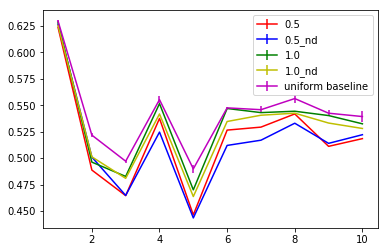

In [10]:
# cumulative test accuracy (only over the classes learnt one at a time) after each increment of training
for sigma in sigmas:
    test_accuracy_mean[sigma], test_accuracy_std[sigma] = [], [] 
    test_accuracy_mean_nd[sigma], test_accuracy_std_nd[sigma] = [], []
    for i in range(len(epsilons)):
        epsilon = epsilons[i]
        test_acc_file_name = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt) + \
                                'T=' + str(T) + 'alpha=' + str(alpha)
        file_path = summaries_path + test_acc_file_name + '_test_accuracies.dat'
        cur_mean, cur_std = loadMeanStd(file_path, final=False, num_repeat_expt=1)
        test_accuracy_mean[sigma].append(cur_mean)
        test_accuracy_std[sigma].append(cur_std)
        
        test_acc_file_name_nd = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt)
        file_path_nd = summaries_path_nd + test_acc_file_name_nd + '_test_accuracies.dat'
        cur_mean_nd, cur_std_nd = loadMeanStd(file_path_nd, final=False, num_repeat_expt=1)
        test_accuracy_mean_nd[sigma].append(cur_mean_nd)
        test_accuracy_std_nd[sigma].append(cur_std_nd)
        
        plt.errorbar(range(1, test_accuracy_mean[sigma][-1].shape[0] + 1), test_accuracy_mean[sigma][-1], yerr=test_accuracy_std[sigma][-1], color=colors[i], label=str(epsilon))
        plt.errorbar(range(1, test_accuracy_mean_nd[sigma][-1].shape[0] + 1), test_accuracy_mean_nd[sigma][-1], yerr=test_accuracy_std_nd[sigma][-1], color=colors_nd[i], label=str(epsilon) + '_nd')
    print("sigma:", sigma)
    plt.errorbar(range(1, baseline_mean.shape[0] + 1), baseline_mean, yerr=baseline_std, color='m', label='uniform baseline')
    plt.legend()
    plt.show()

#### Graph with constant epsilon; test accuracy vs sigma

In [ ]:
# constant epsilon, test accuracy with varying sigma
test_accuracy_mean_e = {}
test_accuracy_std_e = {}
test_accuracy_mean_nd_e = {}
test_accuracy_std_nd_e = {}

# constant sigma, test accuracy with varying epsilon
for epsilon in epsilons:
    test_accuracy_mean_e[epsilon], test_accuracy_std_e[epsilon] = [], [] 
    test_accuracy_mean_nd_e[epsilon], test_accuracy_std_nd_e[epsilon] = [], []
    for sigma in sigmas:
        test_acc_file_name = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt) + \
                                'T=' + str(T) + 'alpha=' + str(alpha)
        file_path = summaries_path + test_acc_file_name + '_test_accuracies.dat'
        cur_mean, cur_std = loadMeanStd(file_path)
        test_accuracy_mean_e[epsilon].append(cur_mean)
        test_accuracy_std_e[epsilon].append(cur_std)
        
        test_acc_file_name_nd = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt)
        file_path_nd = summaries_path_nd + test_acc_file_name_nd + '_test_accuracies.dat'
        cur_mean_nd, cur_std_nd = loadMeanStd(file_path_nd)
        test_accuracy_mean_nd_e[epsilon].append(cur_mean_nd)
        test_accuracy_std_nd_e[epsilon].append(cur_std_nd)
        
    print("epsilon:", epsilon)
    test_accuracy_mean_e[epsilon] = np.array(test_accuracy_mean_e[epsilon])
    test_accuracy_std_e[epsilon] = np.array(test_accuracy_std_e[epsilon])
    test_accuracy_mean_nd_e[epsilon] = np.array(test_accuracy_mean_nd_e[epsilon])
    test_accuracy_std_nd_e[epsilon] = np.array(test_accuracy_std_nd_e[epsilon])
    for i in range(test_accuracy_mean_e[epsilon].shape[1]):
        print("task:", i)
        plt.errorbar(np.log(sigmas), test_accuracy_mean_e[epsilon][:, i], yerr=test_accuracy_std_e[epsilon][:, i], color='g')
        plt.errorbar(np.log(sigmas), test_accuracy_mean_nd_e[epsilon][:, i], yerr=test_accuracy_std_nd_e[epsilon][:, i], color='b')
        plt.show()

#### Effect of varying sigma (finer variation within 1.0 - 20.0) for fixed epsilon

In [ ]:
# effect of sigma for fixed epsilon
epsilon = 0.5
sigmas = [1.0, 2.0, 5.0, 7.0, 10.0, 15.0, 20.0]
fix_eps_test_accuracy_mean_nd = []
fix_eps_test_accuracy_std_nd = []
for sigma in sigmas:
    test_acc_file_name = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt)
    file_path_nd = summaries_path_nd + test_acc_file_name + '_test_accuracies.dat'
    cur_mean_nd, cur_std_nd = loadMeanStd(file_path_nd)
    fix_eps_test_accuracy_mean_nd.append(cur_mean_nd)
    fix_eps_test_accuracy_std_nd.append(cur_std_nd)
        
print("epsilon:", epsilon)
fix_eps_test_accuracy_mean_nd = np.array(fix_eps_test_accuracy_mean_nd)
fix_eps_test_accuracy_std_nd = np.array(fix_eps_test_accuracy_std_nd)
for i in range(fix_eps_test_accuracy_mean_nd.shape[1]):
    print("task:", i)
    plt.errorbar(np.log(sigmas), fix_eps_test_accuracy_mean_nd[:, i], yerr=fix_eps_test_accuracy_std_nd[:, i], color='g')
    plt.show()

### Tuning alpha to make performance of new task better compared to no distill

In [ ]:
# alpha tuning, comparing it with no_distill
old_new = 5.0
sigma = 10.0
epsilons = [0.0, 0.2, 0.5, 1.0]
alphas = [0.0, 0.1, 0.2, 0.5, 0.7, 1.0]
# alphas = [0.0]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
num_repeat_expt = 10
T = 5

alpha_tuner_mean, alpha_tuner_std  = {}, {}
alpha_tuner_mean_nd, alpha_tuner_std_nd = [], []
plt_figures = []
plt_axes = []

In [ ]:
# constant sigma, test accuracy with varying epsilon
for i in range(len(alphas)):
    alpha = alphas[i]
    color = colors[i]
    alpha_tuner_mean[alpha], alpha_tuner_std[alpha] = [], []
    for epsilon in epsilons:
        test_acc_file_name = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt) + \
                                'T=' + str(T) + 'alpha=' + str(alpha)
        file_path = summaries_path + test_acc_file_name + '_test_accuracies.dat'
        cur_mean, cur_std = loadMeanStd(file_path)
        alpha_tuner_mean[alpha].append(cur_mean)
        alpha_tuner_std[alpha].append(cur_std)
        
    alpha_tuner_mean[alpha] = np.array(alpha_tuner_mean[alpha])
    alpha_tuner_std[alpha] = np.array(alpha_tuner_std[alpha])
    for j in range(alpha_tuner_mean[alpha].shape[1]):
#         print("task:", j)
        if (i == 0):
            plt_figures.append(plt.figure())
            plt_axes.append(plt_figures[j].add_subplot(1, 1, 1))
        
        plt_axes[j].errorbar(epsilons, alpha_tuner_mean[alpha][:, j], yerr=alpha_tuner_std[alpha][:, j], color=color, label=str(alpha))

# for epsilon in epsilons:
#     test_acc_file_name = 'new:old=' + str(new_old) + 'epsilon=' + str(epsilon) + 'sigma=' + str(sigma) + 'num_repeat_expt=' + str(num_repeat_expt)
#     file_path = summaries_path_nd + test_acc_file_name + '_test_accuracies.dat'
#     cur_mean, cur_std = loadMeanStd(file_path)
#     alpha_tuner_mean_nd.append(cur_mean)
#     alpha_tuner_std_nd.append(cur_std)

# alpha_tuner_mean_nd = np.array(alpha_tuner_mean_nd)
# alpha_tuner_std_nd = np.array(alpha_tuner_std_nd)
# for j in range(alpha_tuner_mean_nd.shape[1]):
#     print("task:", j)
#     plt_axes[j].errorbar(epsilons, alpha_tuner_mean_nd[:, j], yerr=alpha_tuner_std_nd[:, j], color=colors[-1], label='no distill')

for j in range(alpha_tuner_mean[alpha].shape[1]):
#     plt_axes[j].legend()
    plt_figures[j].legend()
plt.show()